# Work with the UTA GTFS files

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, LineString
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
gtfs_dir = '../gtfs Nov 18'
routes = pd.read_csv(os.path.join(gtfs_dir, 'routes.txt'))
shapes = pd.read_csv(os.path.join(gtfs_dir, 'shapes.txt'))
trips = pd.read_csv(os.path.join(gtfs_dir, 'trips.txt'))
stops = pd.read_csv(os.path.join(gtfs_dir, 'stops.txt'))
stop_times = pd.read_csv(os.path.join(gtfs_dir, 'stop_times.txt'), dtype={'stop_id': object})
calendar = pd.read_csv(os.path.join(gtfs_dir, 'calendar.txt'))

# There can be some weird stop_ids in stop_times
May need to adjust dtypes of all IDs to be the same.

In [3]:
len(stop_times)

1414481

In [4]:
bad_stop_ids = stop_times['stop_id'].apply(lambda x: (not str(x).isnumeric()))

In [5]:
bad_stops = stop_times[bad_stop_ids]
len(bad_stops)

14387

In [6]:
bad_stops.head(3)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
506,3566652,18:18:26,18:18:26,20785_merged_3782534,7,NaN,NaN,NaN,NaN,NaN
593,3566653,16:03:26,16:03:26,20785_merged_3782534,7,NaN,NaN,NaN,NaN,NaN
730,3566656,09:41:21,09:41:21,20785_merged_3782534,7,NaN,NaN,NaN,NaN,NaN


# Transform gtfs shapes to lines

In [7]:
shapes['coords'] = tuple(zip(shapes['shape_pt_lon'], shapes['shape_pt_lat']))

In [8]:
shapes = shapes.sort_values(by=['shape_id', 'shape_pt_sequence'])

In [9]:
shapes.head(3)

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled,coords
102558,168743,40.763180,-111.90910,1,0.0000,"(-111.9091, 40.76318)"
102559,168743,40.763250,-111.90904,2,0.0093,"(-111.90903999999999, 40.76325)"
102560,168743,40.764009,-111.90894,3,0.0130,"(-111.90893999999999, 40.764009)"


## There are some repeated vertices in shapes
From `gtfs Nov 18` data `shape_pt_seguence` 271 and 269

odd_shape = shapes.groupby('shape_id').get_group(168944)
odd_shape.tail()

## Make stop sequences into lines

In [10]:
line_lists = shapes.groupby('shape_id').agg({'shape_id': 'first', 'shape_dist_traveled': 'sum', 'coords': lambda c: (c.tolist())})

In [11]:
line_lists.head()

,shape_id,shape_dist_traveled,coords
shape_id,,,
168743,168743,1360.3743,"[(-111.9091, 40.76318), (-111.90903999999999, ..."
168744,168744,1397.7476,"[(-111.83755, 40.772409), (-111.837799, 40.772..."
168745,168745,1175.5721,"[(-111.89701000000001, 40.7247), (-111.89702, ..."
168746,168746,868.5537,"[(-111.83948000000001, 40.77047), (-111.83898,..."
168747,168747,644.1306,"[(-111.9091, 40.76318), (-111.90903999999999, ..."


In [12]:
line_lists['coords'] = line_lists['coords'].apply(LineString)

In [13]:
gtfs_shapes = gpd.GeoDataFrame(line_lists, geometry='coords')
gtfs_shapes.crs = {'init' :'epsg:4326'}
gtfs_shapes.head()

,shape_id,shape_dist_traveled,coords
shape_id,,,
168743,168743,1360.3743,"LINESTRING (-111.9091 40.76318, -111.90904 40...."
168744,168744,1397.7476,"LINESTRING (-111.83755 40.772409, -111.837799 ..."
168745,168745,1175.5721,"LINESTRING (-111.89701 40.7247, -111.89702 40...."
168746,168746,868.5537,"LINESTRING (-111.83948 40.77047, -111.83898 40..."
168747,168747,644.1306,"LINESTRING (-111.9091 40.76318, -111.90904 40...."


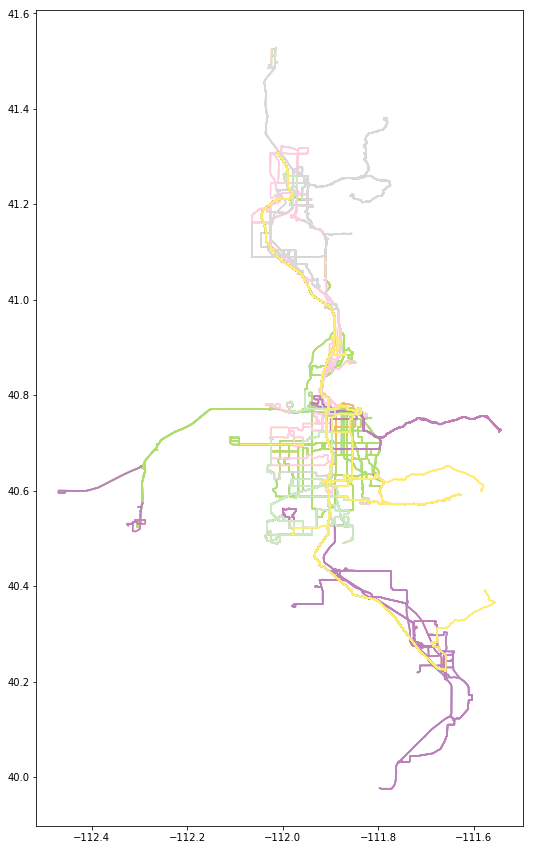

In [14]:
gtfs_shapes.plot(cmap='Set3', figsize=(25,15))

In [15]:
gtfs_shapes.to_file('data/gtfs_shapes.shp')

C:\Users\kwalker\AppData\Local\ESRI\conda\envs\geofun\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


### function created from this work: 

[transform_shape_to_lines](parse_functions.py)

# Transform gtfs stops to points

In [16]:
stops.head(3)

,stop_lat,stop_code,stop_lon,stop_id,stop_url,parent_station,stop_desc,stop_name,location_type,zone_id
0,41.166905,629050,-111.962747,11541,NaN,NaN,E 5300 S,5300 S @ 711 E,0,NaN
1,41.206463,623264,-111.970663,11546,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3180 S,0,NaN
2,41.199655,623261,-111.970843,11544,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3500 S,0,NaN


In [17]:
stops['coords'] = list(zip(stops['stop_lon'], stops['stop_lat']))
stops['coords'] = stops['coords'].apply(Point)
stops.set_index('stop_id', inplace=True)
stops['stop_id'] = stops.index
stop_points = gpd.GeoDataFrame(stops, geometry='coords')
stop_points.head(3)

,stop_lat,stop_code,stop_lon,stop_url,parent_station,stop_desc,stop_name,location_type,zone_id,coords,stop_id
stop_id,,,,,,,,,,,
11541,41.166905,629050,-111.962747,NaN,NaN,E 5300 S,5300 S @ 711 E,0,NaN,POINT (-111.962747 41.166905),11541
11546,41.206463,623264,-111.970663,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3180 S,0,NaN,POINT (-111.970663 41.206463),11546
11544,41.199655,623261,-111.970843,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3500 S,0,NaN,POINT (-111.970843 41.199655),11544


(-111.7, -112.1)

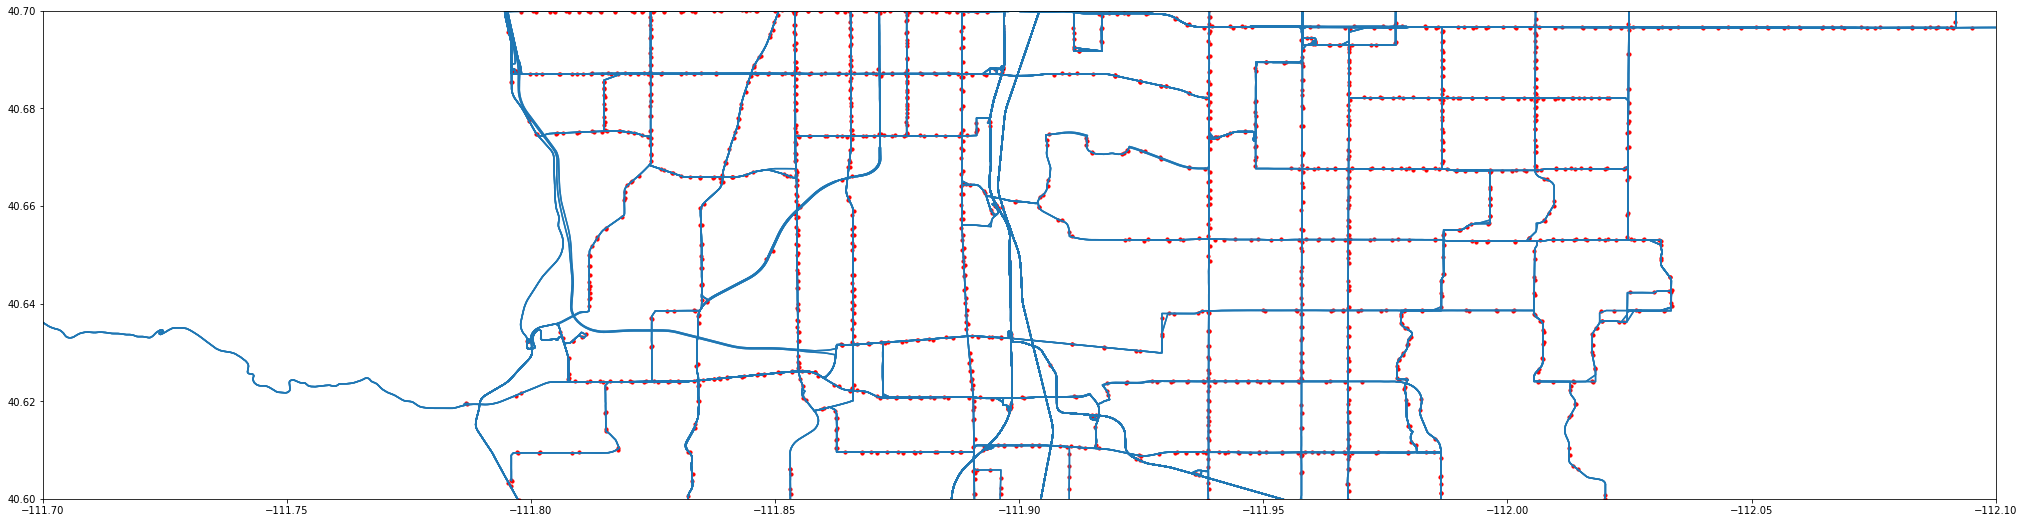

In [18]:
base = gtfs_shapes.plot(figsize=(35,15))
stop_points.plot(ax=base, marker='o', color='red', markersize=10);
plt.ylim(40.6, 40.7)
plt.xlim(-111.7, -112.1)


In [19]:
stop_points.head()

,stop_lat,stop_code,stop_lon,stop_url,parent_station,stop_desc,stop_name,location_type,zone_id,coords,stop_id
stop_id,,,,,,,,,,,
11541,41.166905,629050,-111.962747,NaN,NaN,E 5300 S,5300 S @ 711 E,0,NaN,POINT (-111.962747 41.166905),11541
11546,41.206463,623264,-111.970663,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3180 S,0,NaN,POINT (-111.970663 41.206463),11546
11544,41.199655,623261,-111.970843,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 3500 S,0,NaN,POINT (-111.970843 41.199655),11544
11548,41.212617,623267,-111.970515,NaN,NaN,S WASHINGTON BLVD,WASHINGTON BLVD @ 2890 S,0,NaN,POINT (-111.970515 41.212617),11548
22260,40.687488,BB101571,-111.796897,NaN,NaN,S WASATCH BLVD,WASATCH BLVD @ 3900 S,0,NaN,POINT (-111.796897 40.687488),22260


In [20]:
stop_points.crs = {'init' :'epsg:4326'}
stop_points.to_file('data/stop_points.shp')

C:\Users\kwalker\AppData\Local\ESRI\conda\envs\geofun\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


# Find the shapes per route

In [113]:
stop_times.set_index('trip_id', inplace=True)
trips.set_index('trip_id', inplace=True)
trip_stops = trips.join(stop_times, lsuffix='', rsuffix='_stops')

In [117]:
trip_stops = trip_stops.reset_index()
trip_stops.head()

,trip_id,block_id,route_id,direction_id,trip_headsign,shape_id,service_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint
0,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:24:00,08:24:00,21168,1,NaN,NaN,NaN,NaN,NaN
1,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:29:14,08:29:14,5479,2,NaN,NaN,NaN,NaN,NaN
2,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:29:57,08:29:57,24221,3,NaN,NaN,NaN,NaN,NaN
3,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:30:57,08:30:57,5481,4,NaN,NaN,NaN,NaN,NaN
4,3522177,a_981126,74606,0,University Medical Center,168743,4_merged_3782668,08:32:13,08:32:13,13105,5,NaN,NaN,NaN,NaN,NaN


In [119]:
route_shapes = trip_stops.groupby(['route_id', 'trip_id']).agg(['count'])['stop_id']

In [122]:
route_shapes.head(50)

count
route_id trip_id       
74606    3522177     37
         3522178     37
         3522179     37
         3522180     37
         3522181     37
         3522182     37
         3522183     37
         3522184     37
         3522185     37
         3522186     37
         3522187     37
         3522188     37
         3522189     37
         3522190     37
         3522191     37
         3522192     37
         3522193     37
         3522194     37
         3522195     37
         3522196     40
         3522197     40
         3522198     40
         3522199     40
         3522200     40
         3522201     40
         3522202     40
         3522203     40
         3522204     40
         3522205     40
         3522206     40
         3522207     40
         3522208     40
         3522209     40
         3522210     40
         3522211     40
         3522212     40
         3522213     40
74607    3522214     34
         3522215     34
         3522216     34
         3522217     34
         3522218     34
         3522219     34
         3522220     34
         3522221     34
         3522222     34
         3522223     34
         3522224     34
         3522225     34
         3522226     34

In [80]:
# route_shapes.sort_values('count', ascending=False)
# route_shapes.reset_index()

In [123]:
route_shape_counts = route_shapes.reset_index()
idx = route_shape_counts.groupby(['route_id'])['count'].transform(max) == route_shape_counts['count']
g = route_shape_counts[idx]
group = g.groupby(['route_id']).first()

In [124]:
group.head()

,trip_id,count
route_id,,
74606,3522196,40
74607,3522214,34
74608,3522339,22
74609,3522785,50
74610,3523164,45


In [125]:
group.shape

(243, 2)